In [2]:
import pandas as pd
import os
from pathlib import Path
import numpy as np
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.model_selection import cross_val_score
import pickle

In [127]:
cur_file = Path(os.getcwd())
working_dir = cur_file.parent
parent_dir = working_dir.parent
data_dir = parent_dir.joinpath('data')

In [128]:
org_dir = data_dir.joinpath('processed/preprocess_1')
syn_dir = data_dir.joinpath('processed/decoded')

In [129]:
train = pd.read_pickle(org_dir.joinpath('train_ori_50.pkl'))
test = pd.read_pickle(org_dir.joinpath('test_50.pkl'))
syn = pd.read_csv(syn_dir.joinpath('Synthetic_data_epsilon10000.csv'),index_col = 0)
#syn = pd.read_csv('/home/dogu86/2022_DATA_SYNTHESIS/young_age/Synthetic_data_epsilon0_50.csv',index_col=0)
#syn = pd.read_csv('/home/dogu86/young_age_colon_cancer/final_data/synthetic_decoded/Synthetic_data_epsilon10000.csv')
syn.rename(columns = {'RLPS_DIFF' : 'RLPS DIFF'}, inplace = True)

In [130]:
test_x = test.drop(['DEAD','DEAD_DIFF','PT_SBST_NO'], axis=1)
test_x = test_x.replace(np.NaN,999)

In [131]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
test_x = scaler.fit_transform(test_x)

In [8]:
def get_feature_importances(model,feature):
    import seaborn as sns
    import matplotlib.pyplot as plt

    importances = model.feature_importances_
    #feature = x.columns
    imp, feat = (list(x) for x in zip(*sorted(zip(importances, feature), reverse=True)))

    plt.figure(figsize=(13, 10))
    sns.barplot(imp[:30], feat[:30])
    plt.xlabel('Importance')
    plt.ylabel('Feature')
    plt.title('Classification Feature Importances (Top 30)', fontsize=18)
    plt.show()

In [9]:
def get_best_model(data,valid,model_name):

    if model_name in ['dt','rf']:
        grid_parameters = {"max_depth": [2,4,5,7,9,10,50],
                       "min_samples_split": [2,3,4]}
        return tree_like(model_name,data,valid,grid_parameters)
        
    elif model_name == 'xgb':
        grid_parameters = {"max_depth": [4,5,7,10,50], 
                           'learning_rate':[0.01, 0.1]}
        return get_xgb(model_name,data,valid,grid_parameters)
        
    else:
        print('model name error')
        return 0

In [10]:
def tree_like(model_name,data,valid,param):
    
    x, y, valid_x, valid_y = get_data(data,valid)
    cnt = 0
    prev = 0
    
    scaler = StandardScaler()
    x = scaler.fit_transform(x)
    valid_x = scaler.fit_transform(valid_x)
    
    scores = []
    models = []
    
    for i in range(len(param['max_depth'])):
        for k in range(len(param['min_samples_split'])):
            if model_name == 'dt':
                model = DecisionTreeClassifier(max_depth = param['max_depth'][i], 
                                               min_samples_split=param['min_samples_split'][k])
            elif model_name == 'rf':
                model = RandomForestClassifier(max_depth = param['max_depth'][i], 
                                               min_samples_split=param['min_samples_split'][k],n_jobs=-1)

            
            model.fit(x,y)
            
            cur_score = cross_val_score(model,valid_x,valid_y,scoring='f1_macro',cv=10,n_jobs=-1).mean()
            
            scores.append(cur_score)
            models.append(model)
    
    best_idx = scores.index(max(scores))
    
    print(max(scores), models[best_idx])
    
    return models[best_idx]


In [76]:
def get_xgb(model_name,data,valid,param):
    x, y, valid_x, valid_y = get_data(data,valid)
    
    cnt = 0
    prev = 0
    scores = []
    models = []    
    evals = [(valid_x, valid_y)]
    
        
    scaler = StandardScaler()
    x = scaler.fit_transform(x)
    valid_x = scaler.fit_transform(valid_x)
    
    for i in range(len(param['max_depth'])):
        for k in range(len(param['learning_rate'])):
            model = XGBClassifier(n_estimators=100, early_stoping_rounds=50,eval_set=evals,
                learning_rate=param['learning_rate'][k], 
                                        max_depth=param['max_depth'][i],objective='binary:logistic',n_jobs=-1)

            model.fit(x, y,verbose=True,early_stopping_rounds=100, 
                        eval_metric='logloss',eval_set=evals)

            cur_score = cross_val_score(model,valid_x,valid_y,scoring='f1_macro',cv=3,n_jobs=-1).mean()

            scores.append(cur_score)
            models.append(model)   
                
    best_idx = scores.index(max(scores))
    
    print(max(scores), models[best_idx])
    
    return models[best_idx]

In [11]:
def get_data(data,test):
    data = data.drop(['PT_SBST_NO'],axis=1)
    data = data.astype(float)


    x = data.drop(['DEAD','DEAD_DIFF'], axis=1)
    x = x.replace(np.NaN,999)
    y = data['DEAD']
    
    
    test_x = test.drop(['DEAD','DEAD_DIFF','PT_SBST_NO'], axis=1)
    test_x = test_x.replace(np.NaN,999)
    test_y = test['DEAD']
    
    
    return [x,y,test_x,test_y]

In [134]:
real_valid = train.sample(int(len(train)*0.25))
real_train = train.drop(real_valid.index)



# Get Train Syn - Valid Real
dt_model = get_best_model(syn,real_valid,'dt')
rf_model = get_best_model(syn,real_valid,'rf')
#xgb_model = get_best_model(syn,real_valid,'xgb')
tstr_models = [dt_model,rf_model,xgb_model]

# Get Train Real - Valid Real
dt_model_real = get_best_model(real_train,real_valid,'dt')
rf_model_real = get_best_model(real_train,real_valid,'rf')
#xgb_model_real = get_best_model(real_train,real_valid,'xgb')
trtr_models = [dt_model_real,rf_model_real,xgb_model_real
               

0.759373758351476 DecisionTreeClassifier(max_depth=10)
0.6612557700034574 RandomForestClassifier(max_depth=9, min_samples_split=4, n_jobs=-1)
0.7592915848705599 DecisionTreeClassifier(max_depth=7, min_samples_split=3)
0.6562526864388566 RandomForestClassifier(max_depth=50, min_samples_split=3, n_jobs=-1)


In [ ]:
train

In [83]:
syn_valid = syn.sample(int(len(train)*0.25))
syn_train = syn.drop(syn_valid.index)

# Get Train Syn - Valid Syn
dt_model_tsts = get_best_model(syn_train,syn_valid,'dt')
rf_model_tsts = get_best_model(syn_train,syn_valid,'rf')
#xgb_model_tsts = get_best_model(syn_train,syn_valid,'xgb')
tsts_models = [dt_model_tsts,rf_model_tsts,xgb_model_tsts]

# Get Train Real - Valid Syn
dt_model_trts = get_best_model(real_train,syn_valid,'dt')
rf_model_trts = get_best_model(real_train,syn_valid,'rf')
#xgb_model_trts = get_best_model(real_train,syn_valid,'xgb')
trts_models = [dt_model_trts,rf_model_trts,xgb_model_trts]

0.7980135676209514 DecisionTreeClassifier(max_depth=5, min_samples_split=3)
0.7903223801917137 RandomForestClassifier(max_depth=10, min_samples_split=4, n_jobs=-1)
0.7946505504601457 DecisionTreeClassifier(max_depth=5, min_samples_split=3)
0.7930321272497611 RandomForestClassifier(max_depth=10, min_samples_split=3, n_jobs=-1)


In [199]:
#모델 저장

save_dir = cur_file.joinpath('ml_models')

with open(save_dir.joinpath('trts_models.pkl'), 'wb') as f:
    pickle.dump(trts_models, f, protocol=pickle.HIGHEST_PROTOCOL)
with open(save_dir.joinpath('tstr_models.pkl'), 'wb') as f:
    pickle.dump(trts_models, f, protocol=pickle.HIGHEST_PROTOCOL)
with open(save_dir.joinpath('tsts_models.pkl'), 'wb') as f:
    pickle.dump(trts_models, f, protocol=pickle.HIGHEST_PROTOCOL)
with open(save_dir.joinpath('trtr_models.pkl'), 'wb') as f:
    pickle.dump(trtr_models, f, protocol=pickle.HIGHEST_PROTOCOL)
    


In [16]:
# load
'''with open('trts_models.pkl', 'rb') as f:
    trts_models = pickle.load(f)
with open('tstr_models.pkl', 'rb') as f:
    tstr_models = pickle.load(f)
with open('tsts_models.pkl', 'rb') as f:
    tsts_models = pickle.load(f)
with open('trtr_models.pkl', 'rb') as f:
    trtr_model = pickle.load(f)
'''


In [92]:
model_arr = [trtr_models,tstr_models,trts_models,tsts_models]
score_by_case = []
for models in model_arr:
    scores = []
    for model in models:
        f1 = cross_val_score(model,test_x,test['DEAD'],scoring='f1_macro',cv=10,n_jobs=-1).mean()
        scores.append(f1)
    score_by_case.append(scores)
    

In [132]:
len(test_x[0])

83

In [133]:
from sklearn.metrics import f1_score
for models in model_arr:
    scores = []
    for model in models:
        pred = model.predict(test_x)
        f1 = f1_score(test['DEAD'],pred,average='macro')
        scores.append(f1)
    score_by_case.append(scores)

/home/dogu86/.conda/envs/synthetic_data/lib/python3.8/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but DecisionTreeClassifier was fitted with feature names
  warnings.warn(
/home/dogu86/.conda/envs/synthetic_data/lib/python3.8/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(
/home/dogu86/.conda/envs/synthetic_data/lib/python3.8/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but DecisionTreeClassifier was fitted with feature names
  warnings.warn(


ValueError: X has 83 features, but DecisionTreeClassifier is expecting 84 features as input.

In [93]:
np.array(score_by_case)


array([[0.66707116, 0.71720865, 0.69077921],
       [0.63373783, 0.66351135, 0.69077921],
       [0.5759595 , 0.67456873, 0.70244531],
       [0.63030053, 0.64138307, 0.70244531]])

Text(0.5, 1.0, 'Epsilon 10000, Train Strategy')

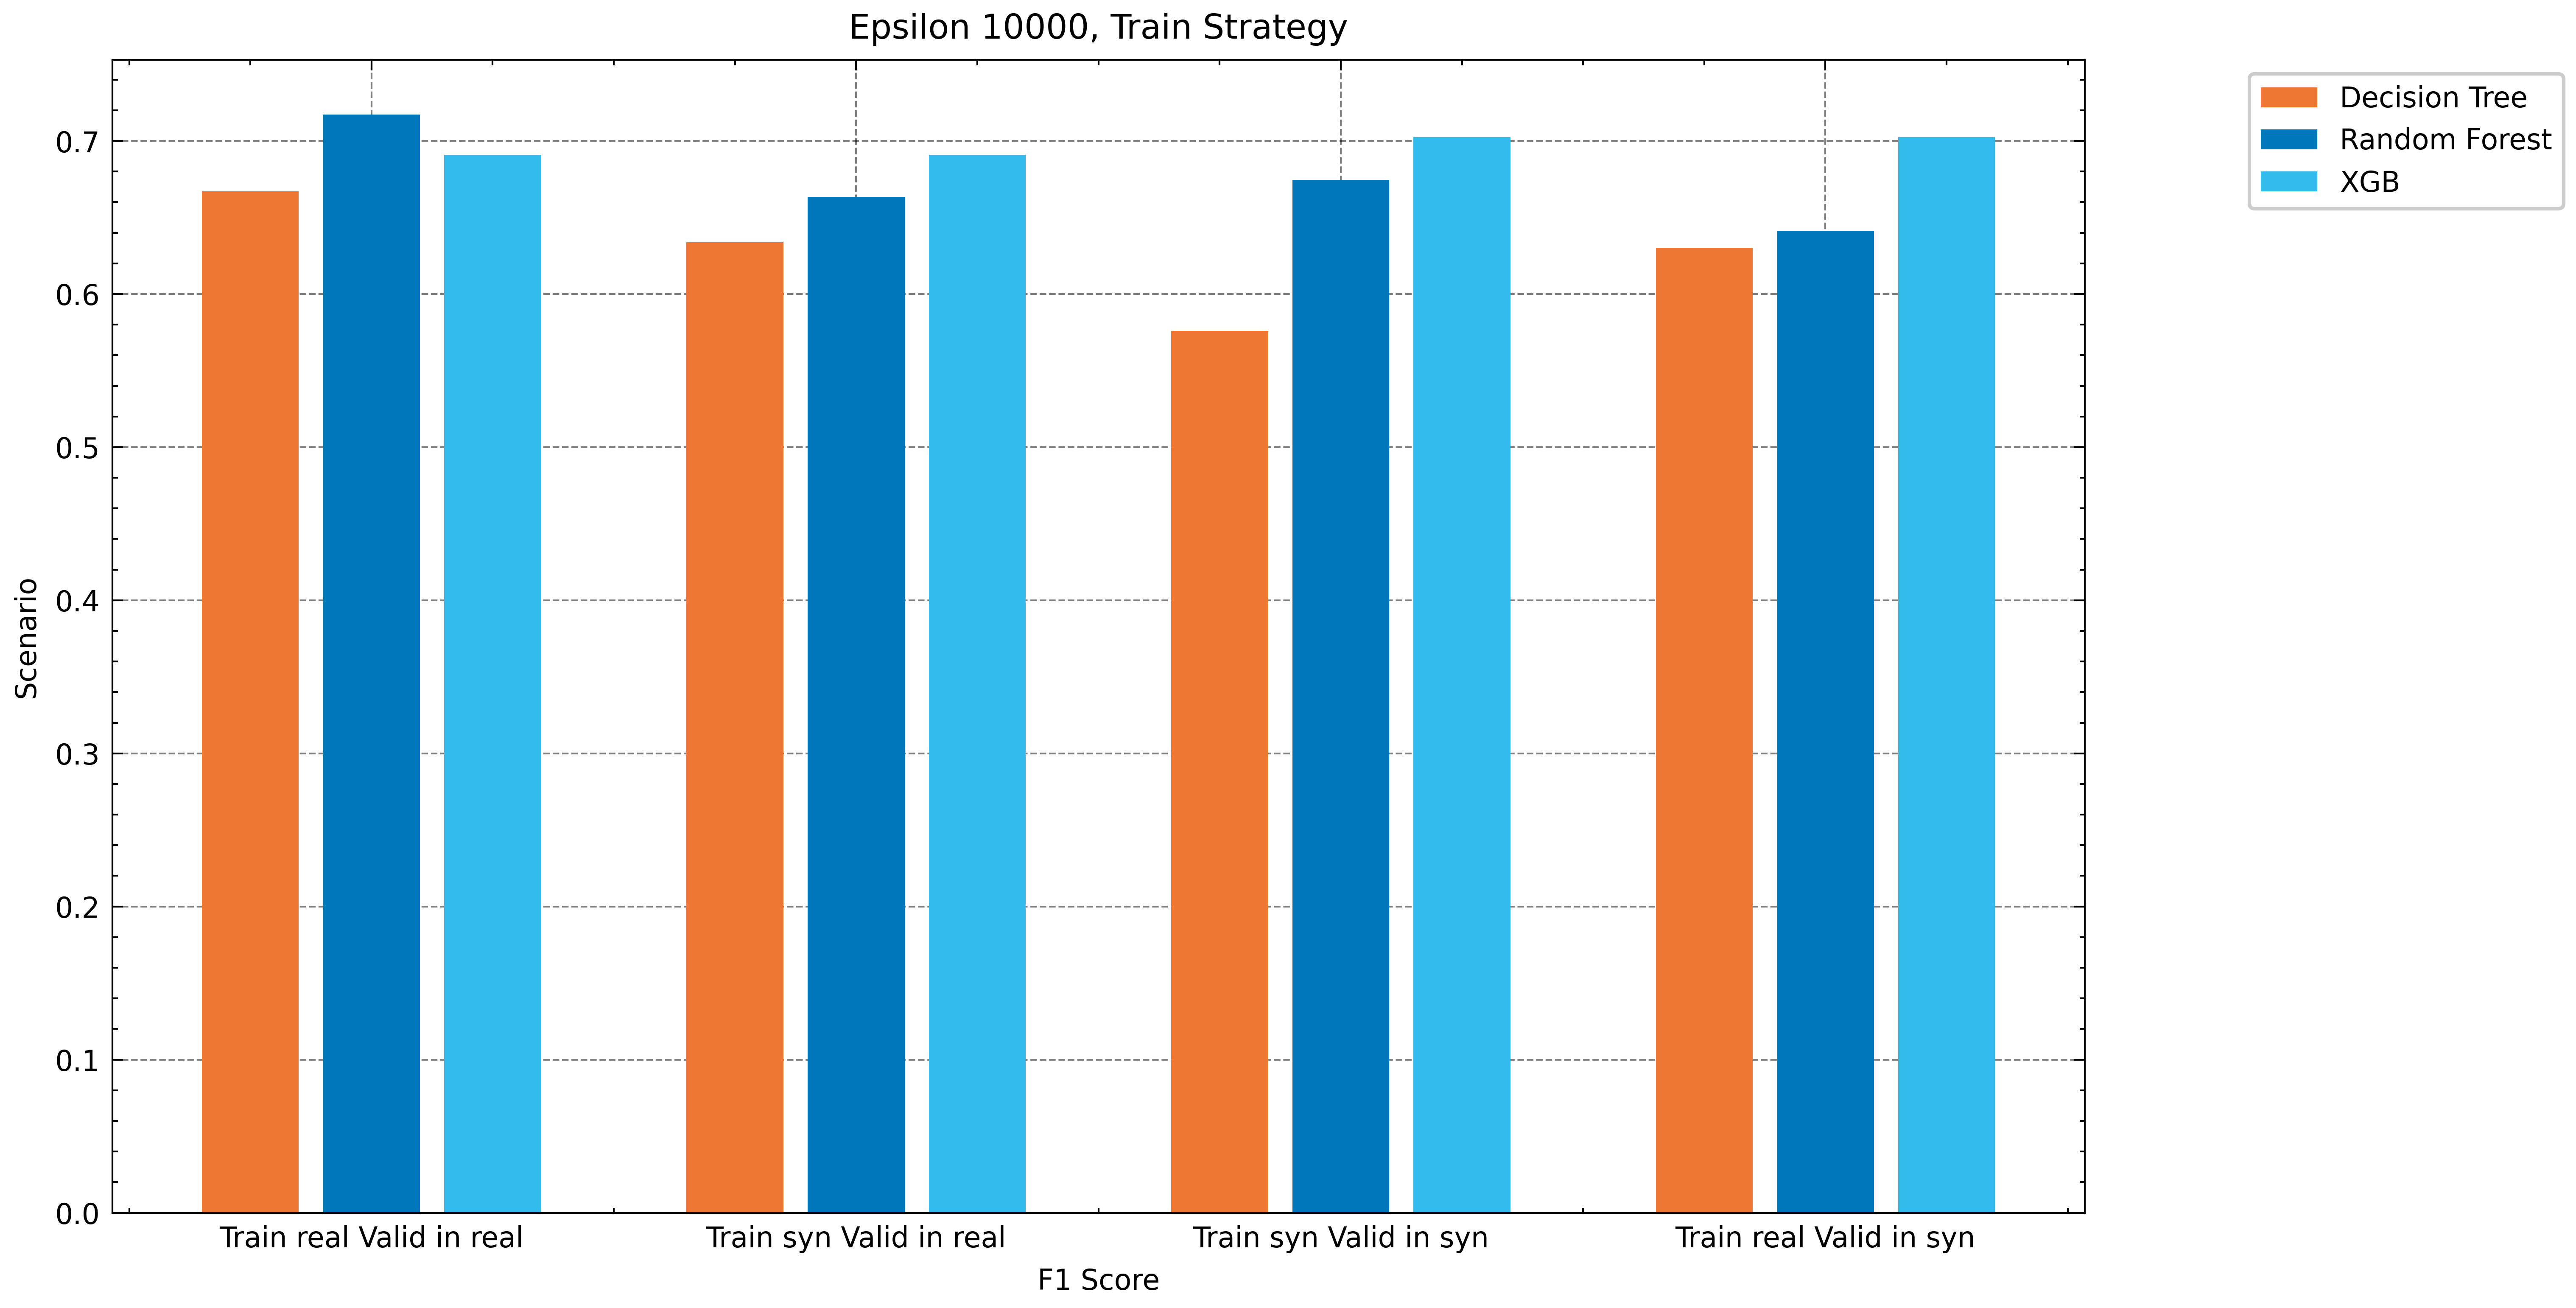

In [94]:
import matplotlib.pyplot as plt
import scienceplots

plt.style.use(['science','grid','no-latex','vibrant'])
plt.figure(figsize=(10,6))
X1=[1,3,5,7]
data1 = np.array(score_by_case).transpose()[0]
plt.bar(X1, data1,width=0.4,label='Decision Tree')

X2=[1+0.5,3+0.5,5+0.5,7+0.5]
data2 = np.array(score_by_case).transpose()[1]
plt.bar(X2, data2,width=0.4,label='Random Forest')

X3=[1+1,3+1,5+1,7+1]
data3 = np.array(score_by_case).transpose()[2]
plt.bar(X3, data3,width=0.4,label='XGB')

plt.legend(loc='upper right',bbox_to_anchor=(1.25, 1))
ticklabel=['Train real Valid in real','Train syn Valid in real','Train syn Valid in syn','Train real Valid in syn']
plt.xticks(X2,ticklabel)

plt.xlabel('F1 Score')
plt.ylabel('Scenario')

plt.title('Epsilon 10000, Train Strategy')

/home/dogu86/.conda/envs/synthetic_data/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


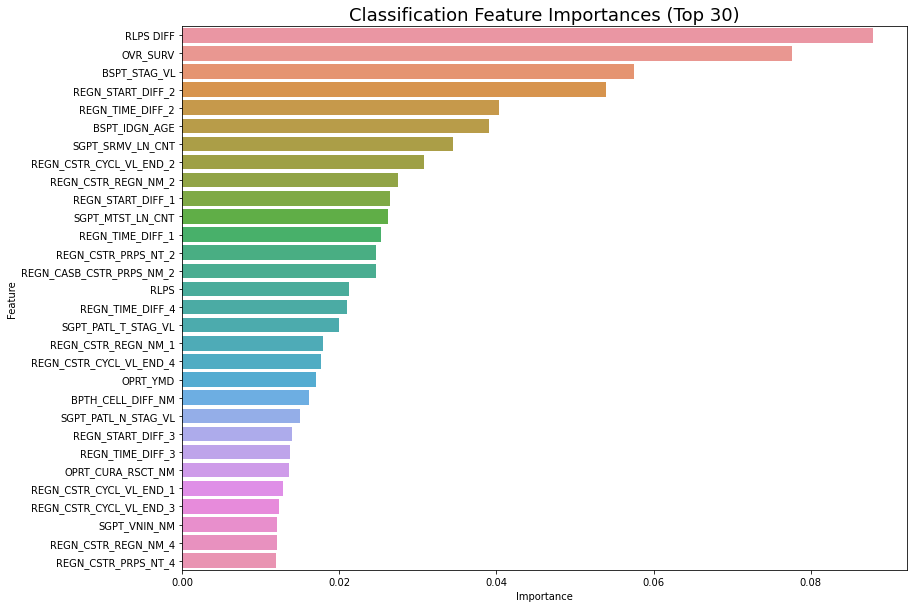

In [25]:
#trtr
get_feature_importances(model_arr[3][1],feature=test_x.columns)

/home/dogu86/.conda/envs/synthetic_data/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


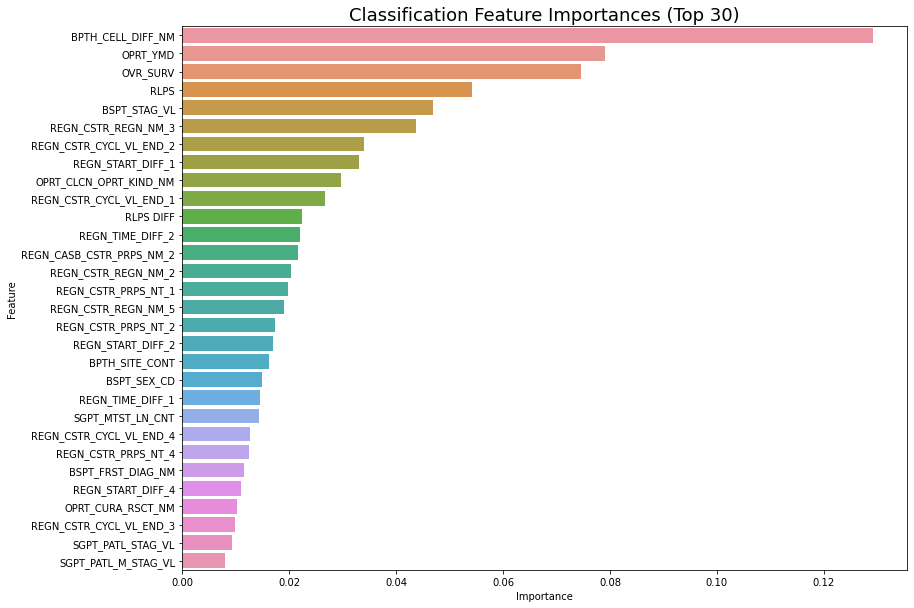

In [26]:
#tstr
get_feature_importances(model_arr[1][1],feature=test_x.columns)

In [28]:
syn['DEAD'].value_counts()

0    2918
1    2092
Name: DEAD, dtype: int64

[10:54:48] WARNING: ../src/learner.cc:767: 
Parameters: { "early_stoping_rounds", "eval_set" } are not used.

[10:54:48] WARNING: ../src/learner.cc:767: 
Parameters: { "early_stoping_rounds", "eval_set" } are not used.

[10:54:48] WARNING: ../src/learner.cc:767: 
Parameters: { "early_stoping_rounds", "eval_set" } are not used.

[10:54:46] WARNING: ../src/learner.cc:767: 
Parameters: { "early_stoping_rounds", "eval_set" } are not used.

[10:54:46] WARNING: ../src/learner.cc:767: 
Parameters: { "early_stoping_rounds", "eval_set" } are not used.

[10:54:46] WARNING: ../src/learner.cc:767: 
Parameters: { "early_stoping_rounds", "eval_set" } are not used.

[10:54:46] WARNING: ../src/learner.cc:767: 
Parameters: { "early_stoping_rounds", "eval_set" } are not used.

[10:54:46] WARNING: ../src/learner.cc:767: 
Parameters: { "early_stoping_rounds", "eval_set" } are not used.

[10:54:49] WARNING: ../src/learner.cc:767: 
Parameters: { "early_stoping_rounds", "eval_set" } are not used.

[10:54:46]

In [38]:
syn['RLPS'].value_counts()

0    2955
1    2055
Name: RLPS, dtype: int64

In [36]:
train['RLPS'].value_counts()

0    853
1    149
Name: RLPS, dtype: int64

In [32]:
syn.columns

Index(['Unnamed: 0', 'PT_SBST_NO', 'BSPT_SEX_CD', 'BSPT_IDGN_AGE',
       'BSPT_FRST_DIAG_NM', 'BSPT_STAG_CLSF_CD', 'BSPT_STAG_VL', 'RLPS',
       'RLPS DIFF', 'DEAD', 'DEAD_DIFF', 'OVR_SURV', 'BPTH_SITE_CONT',
       'BPTH_CELL_DIFF_NM', 'OPRT_YMD', 'OPRT_CLCN_OPRT_KIND_NM',
       'OPRT_CURA_RSCT_NM', 'SGPT_PATL_STAG_VL', 'SGPT_PATL_T_STAG_VL',
       'SGPT_PATL_N_STAG_VL', 'SGPT_PATL_M_STAG_VL', 'SGPT_SRMV_LN_CNT',
       'SGPT_MTST_LN_CNT', 'SGPT_SRMG_PCTS_STAT_NM', 'SGPT_SRMG_DCTS_STAT_NM',
       'SGPT_SRMG_RCTS_STAT_NM', 'SGPT_NERV_PREX_NM', 'SGPT_VNIN_NM',
       'SGPT_ANIN_NM', 'SGPT_TUMR_BUDD_NM', 'MLPT_MSIE_RSLT_NM',
       'MLPT_KE2E_RSLT_NM', 'MLPT_KRES_RSLT_NM', 'MLPT_NREX_RSLT_NM',
       'MLPT_BRME_RSLT_NM', 'IMPT_HM1E_RSLT_NM', 'IMPT_HS2E_RSLT_NM',
       'IMPT_HS6E_RSLT_NM', 'REGN_IMPT_HP2E_RSLT_NM', 'REGN_CSTR_REGN_NM_1',
       'REGN_CSTR_PRPS_NT_1', 'REGN_CASB_CSTR_PRPS_NM_1', 'REGN_TIME_DIFF_1',
       'REGN_START_DIFF_1', 'REGN_CSTR_CYCL_VL_END_1', 'REGN_CSTR_REG

In [42]:
import os
print(os.environ['PATH'])

/opt/apache-maven-3.6.3/bin:/home/dogu86/.vscode-server/bin/e2816fe719a4026ffa1ee0189dc89bdfdbafb164/bin/remote-cli:/opt/rh/devtoolset-9/root/usr/bin:/opt/apache-maven-3.6.3/bin:/opt/rh/devtoolset-9/root/usr/bin:/opt/apache-maven-3.6.3/bin:/usr/condabin:/usr/local/bin:/usr/bin:/usr/local/sbin:/usr/sbin:/usr/local/jvm/jdk1.8.0_241/bin:/usr/local/tesseract-5.0/bin:/home/dogu86/.local/bin:/home/dogu86/bin:/usr/local/jvm/jdk1.8.0_241/bin:/usr/local/tesseract-5.0/bin:/home/dogu86/.local/bin:/home/dogu86/bin
